In [2]:
%pylab inline
import scipy.ndimage
import time
import scipy.sparse.linalg
import scipy.stats
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [3]:
width, height = 64,64

def fill_holes(image):
    height = image.shape[0]
    width = image.shape[1]
    filled = np.zeros((height + 2, width), dtype=bool)
    filled[1:-1,:] = image
    filled = ~scipy.ndimage.binary_fill_holes(~filled)[1:-1,:]
    return filled

def fill_holes_periodic(image):
    height = image.shape[0]
    width = image.shape[1]
    filled = np.zeros((height*3+2, width), dtype=bool)
    filled[1:height+1,:] = image
    filled[height+1:height*2+1,:] = image
    filled[height*2+1:height*3+1,:] = image
    filled = ~scipy.ndimage.binary_fill_holes(~filled)[1:-1,:]
    return filled

def calculate_porosity(im):
    im = np.array(im, dtype=np.float64)
    Vp = np.sum(im == 1)
    Vs = np.sum(im == 0)
    e = Vp / (Vs + Vp)
    return e

def is_porous(image):
    height = image.shape[0]
    width = image.shape[1]
    filled = np.zeros((height + 2, width+1), dtype=bool)
    filled[1:-1,0:-1] = image
    filled = ~scipy.ndimage.binary_fill_holes(~filled)[1:-1,:]
    return np.any(filled[:,-2])

def generate_image_normal(width, height, circles, mean_circle_radius, std_circle_radius, porous = False):
    """ Image generator

        Generate an image of a porous media using the overlapping circles method.
        The circle sizes are generated using a normal distribution

        Args:
            width              (int): Width of the image in pixels
            height             (int): Height of the image in pixels
            circles            (int): Amount of circles to draw
            mean_circle_radius (int): Mean circle radius
            std_circle_radius  (int): Circle radius standard deviation

        Returns:
            numpy.ndarray: 2d array of pixels with True or False as value
    """
    
    xx, yy = np.mgrid[:width, :height]
    
    image = np.zeros((width, height), dtype=bool)
    
    i = 0
    while i < circles:
        # Generate a random circle radius
        circle_radius = np.random.normal(mean_circle_radius, std_circle_radius)
        
        # Generate a x position where the circle is (partly) inside the square
        position_x = np.random.random_sample()*(width+2*circle_radius)-circle_radius
        
        # Generate a y position where the circle is (partly) inside the square
        position_y = np.random.random_sample()*(height+2*circle_radius)-circle_radius
        
        circle = ((xx - position_x)**2 + (yy - position_y)**2) < circle_radius**2
        
        image = image | circle
        i+=1

    img = (~image).reshape(width, height)

    return img

def generate_image_with_porosity(width, height, porosity, mean_circle_radius, std_circle_radius):
    """ Image generator

        Generate an image of a porous media using the overlapping circles method.
        The circle sizes are generated using a normal distribution

        Args:
            width              (int): Width of the image in pixels
            height             (int): Height of the image in pixels
            circles            (int): Amount of circles to draw
            mean_circle_radius (int): Mean circle radius
            std_circle_radius  (int): Circle radius standard deviation

        Returns:
            numpy.ndarray: 2d array of pixels with True or False as value
    """
    
    xx, yy = np.mgrid[:width, :height]
    
    image = np.zeros((width, height), dtype=bool)
    
    i = 0
    while calculate_porosity(image) < 1-porosity:
        # Generate a random circle radius
        circle_radius = np.random.normal(mean_circle_radius, std_circle_radius)
        
        # Generate a x position where the circle is (partly) inside the square
        position_x = np.random.random_sample()*(width+2*circle_radius)-circle_radius
        
        # Generate a y position where the circle is (partly) inside the square
        position_y = np.random.random_sample()*(height+2*circle_radius)-circle_radius
        
        circle = ((xx - position_x)**2 + (yy - position_y)**2) < circle_radius**2
        
        image = image | circle
        i+=1

    return (~image).reshape(width, height)


def generate_image_normal_periodic(width, height, circles, mean_circle_radius, std_circle_radius):
    """ Image generator

        Generate an image of a porous media using the overlapping circles method.
        The circle sizes are generated using a normal distribution

        Args:
            width              (int): Width of the image in pixels
            height             (int): Height of the image in pixels
            circles            (int): Amount of circles to draw
            mean_circle_radius (int): Mean circle radius
            std_circle_radius  (int): Circle radius standard deviation

        Returns:
            numpy.ndarray: 2d array of pixels with True or False as value
    """
    
    xx, yy = np.mgrid[:width, :height]
    
    image = np.zeros((width, height), dtype=bool)
    
    i = 0
    while i < circles:
        # Generate a random circle radius
        circle_radius = np.random.normal(mean_circle_radius, std_circle_radius)
        
        # Generate a x position where the circle is (partly) inside the square
        position_x = np.random.random_sample()*width
        
        # Generate a y position where the circle is (partly) inside the square
        position_y = np.random.random_sample()*height
        
        circle = ((xx - position_x)**2 + (yy - position_y)**2) < circle_radius**2
        
        image = image | circle
        i+=1
        
        # In order to make the image periodic, additional circles are added if neccescary
        if (position_x+circle_radius > width):
            circle = ((xx - position_x + width)**2 + (yy - position_y)**2) < circle_radius**2
            image = image | circle
            i+=1
        if (position_x-circle_radius < 0):
            circle = ((xx - position_x - width)**2 + (yy - position_y)**2) < circle_radius**2
            image = image | circle
            i+=1
        if (position_y+circle_radius > height):
            circle = ((xx - position_x)**2 + (yy - position_y + height)**2) < circle_radius**2
            image = image | circle
            i+=1
        if (position_y-circle_radius < 0):
            circle = ((xx - position_x)**2 + (yy - position_y - height)**2) < circle_radius**2
            image = image | circle
            i+=1
            
    return (~image).reshape(width, height)

def generate_image_gaussian(width, height, sigma = 3, threshold = 0.5, porous=False):
    """ Image generator

        Generate an image of a porous media using a gaussian blur method.
        First, random noise is generated, this is then put through a gaussian filter
        The result of this is then filtered by a treshold value.

        Args:
            width      (int): Width of the image in pixels
            height     (int): Height of the image in pixels
            sigma      (int): Sigma constant in the gaussian distribution
            threshold  (int): Filter threshold

        Returns:
            numpy.ndarray: 2d array of pixels with True or False as value
    """
    
    # Generate 2d random noise
    i = np.random.random((width, height))
    

    # Apply gaussian filter
    i = scipy.ndimage.gaussian_filter(i, sigma=sigma)

    i = np.asarray(i)
    i = (i - i.min()) / (np.ptp(i))
    
    i2 = i < threshold
    
    if porous:
        while not is_porous(i2) or not is_porous(np.rot90(i2)):
            threshold += 0.01
            i2 = i < threshold
    
    return i2.reshape(width, height)

def generate_image_gaussian_periodic(width, height, sigma = 3, threshold = 0.5):
    """ Image generator

        Generate an image of a porous media using a gaussian blur method.
        First, random noise is generated, this is then put through a gaussian filter
        The result of this is then filtered by a treshold value.

        In order to generate an image with periodic boundaries, the gaussian filter is
        taken in the frequency domain using the fourier transformed gaussian function.

        Args:
            width      (int): Width of the image in pixels
            height     (int): Height of the image in pixels
            sigma      (int): Sigma constant in the gaussian distribution
            threshold  (int): Filter threshold

        Returns:
            numpy.ndarray: 2d array of pixels with True or False as value
    """
    
    # Generate 2d random noise
    i = np.random.random((width, height))
    
    # Transform image to frequency domain
    i_fft = np.fft.fft2(i)

    # Apply gaussian filter
    i_fft = scipy.ndimage.fourier_gaussian(i_fft, sigma=sigma)
    
    # Transfer to time domain
    i = ifft2(i_fft)
    
    i = np.asarray(i.real)
    i = (i - i.min()) / (np.ptp(i))
    
    i = i < threshold
    
    return i.reshape(width, height)

Porosity: 0.529


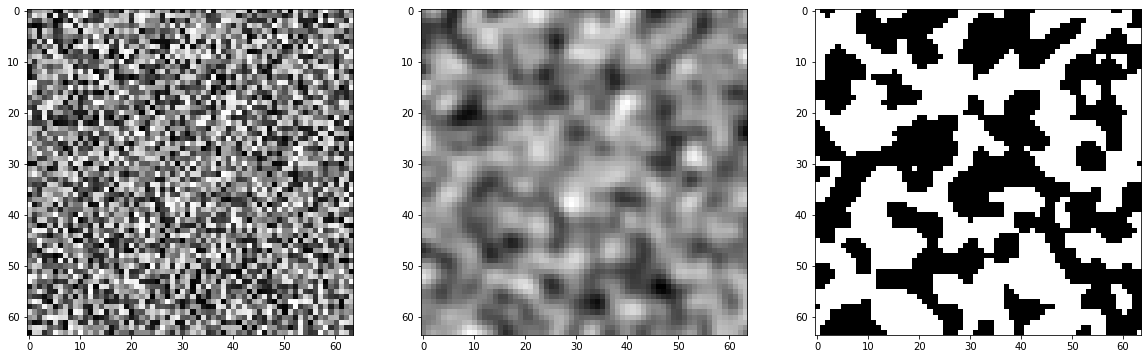

In [4]:
def show_gaussian_generator():
    width, height = (64,64)
    sigma = 1.5
    threshold = 0.5
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))
    
    i1 = np.random.random((width, height))
    i2 = scipy.ndimage.gaussian_filter(i1, sigma=sigma)
    
    i2 = (i2 - i2.min()) / (np.ptp(i2))
    
    threshold = 0.3
    
    i3 = i2 < threshold
    
    while not is_porous(i3) or not is_porous(np.rot90(i3)):
        threshold += 0.01
        i3 = i2 < threshold
    
    ax1.imshow(i1, cmap='gray')
    ax2.imshow(i2, cmap='gray')
    ax3.imshow(i3, cmap='gray')
    
    print("Porosity: {:.3f}".format(calculate_porosity(i3)))
show_gaussian_generator()

To solve:
$$
-\nabla^2 k(x,y)=1
$$

Using taylor expansion:
$$
\left(-\nabla^2 k\right)_{x,y}=\frac{1}{h^2}\left(4k_{x,y}-k_{x-1,y}-k_{x+1,y}-k_{x,y-1}-k_{x,y+1}\right)+\mathcal{O}(h^4)=1
$$
Where $h$ is the step size and $k_{x,y}$ is the value for $k$ at a point $\left(x,y\right)$


This can be used to approximate the value for $k$ at a point $\left(x,y\right)$

$$
k_{x,y} = \frac{h^2+k_{x-1,y}+k_{x+1,y}+k_{x,y-1}+k_{x,y+1}}{4}+\mathcal{O}(h^4)
$$

This equation, can be transformed into a system of equations. This system of equations can be solved easly using a sparse matrix solver.

In [5]:
def get_k_poisson(data, x, y):
    p = data.shape[1]-1
    q = data.shape[0]-1
    
    # Neumann obundary conditions
    t = data[y,x] if y == 0 else data[y-1,x  ]
    b = data[y,x] if y == q else data[y+1,x  ]
    l = data[y,x] if x == 0 else data[y,  x-1]
    r = data[y,x] if x == p else data[y,  x+1]
    
    return np.array((l,r,t,b))

# Using sparse matrices reduces memory and computation complexity by 1000 times
def generate_poisson_matrix_sparse(data):
    """ Sparse system of equations generator
        Create a sparse system of equations for the pressures at each node
    """
    p = data.shape[1]
    q = data.shape[0]

    b_data = []
    b_rows = []
    
    a_data = []
    a_cols = []
    a_rows = []
    
    for x in range(p):
        for y in range(q):
            k_here = data[y,x]
            
            i = x+y*q
            if (k_here == 0):
                a_data.append(1)
                a_rows.append(i)
                a_cols.append(i)
                continue
            
            k = get_k_poisson(data, x, y)
            
            n = 0
            
            if x != 0:
                a_data.append(-k[0])
                a_rows.append(i)
                a_cols.append(i-1)
                n += 1
            
            if x != p-1:
                a_data.append(-k[1])
                a_rows.append(i)
                a_cols.append(i+1)
                n += 1
            
            if y != 0:
                a_data.append(-k[2])
                a_rows.append(i)
                a_cols.append(i-q)
                n += 1
            
            if y != q-1:
                a_data.append(-k[3])
                a_rows.append(i)
                a_cols.append(i+q)
                n += 1
            
            a_data.append(n*k_here)
            a_rows.append(i)
            a_cols.append(i)
            
            b_data.append(1)
            b_rows.append(i)
            
    A = scipy.sparse.coo_matrix((a_data, (a_rows, a_cols)), shape=(p*q, p*q))
    B = scipy.sparse.coo_matrix((b_data, (b_rows, np.zeros(len(b_rows)))), shape=(p*q, 1))
    return A.tocsr(), B.tocsr()

def solve_poisson_matrix_sparse(m, b):
    """ Sparse matrix solver
        Solve the sparse matrix provided by the generate_pressure_matrix_sparse function
    """
    result = scipy.sparse.linalg.spsolve(m, b)
    return result

def calculate_poisson(i):
    """ Calculate the pseudo permeabilities
        using the input i the pseudo permeabilities are returned

        Args:
            i (numpy.ndarray): 2d boolean array of permeable and nonpermeable pixels

        Returns:
            numpy.ndarray: 2d array of pixels with pseudo permeability as value
    """
    # Transform the input to a float array
    j = np.array(i, dtype=np.float64)
    # Generate the system of equations
    A,B = generate_poisson_matrix_sparse(j)
    # Solve the system of equations
    p = solve_poisson_matrix_sparse(A,B).reshape(i.shape)
    return p

To solve:
$$
    \vec{\nabla}\cdot\left(k\vec{\nabla} p\right)=0
$$
Darcy equation
$$
    \vec{q}=-k\vec{\nabla}p
$$

which is transformed into the finite difference equation:

$$
    q = -k\Delta p
$$

Using kirchoffs law, the sum of all incomming and outgoing currents is equal to zero:
$$
\sum q = 0
$$

This can be written as:
$$
    p_{x,y}\left(k_{x-1,y}+k_{x+1,y}+k_{x,y-1}+k_{x,y+1}\right) - p_{x-1,y}k_{x-1,y}-p_{x+1,y}k_{x+1,y}-p_{x,y-1}k_{x,y-1}-p_{x,y+1}k_{x,y+1} = 0
$$

where $k_{x+a,y+b}$ is the permeability/transistivity between the point $(x,y)$ and $(x+a,y+b)$

This can be solved as a system of equations for the entire grid

In [6]:
def sum_k(k1, k2):
    np.seterr(divide='ignore')
    r1 = np.divide(1,k1)
    r2 = np.divide(1,k2)
    rtot = (r1+r2)
    return 1/rtot

def get_k(data, x, y):
    p = data.shape[1]-1
    q = data.shape[0]-1
    
    # dirchet boundary conditions in y
    t = np.float64(0) if y == 0 else data[y-1,x  ]
    b = np.float64(0) if y == q else data[y+1,x  ]
    
    # Neumann boundary conditions in x
    l = data[y,x]     if x == 0 else data[y,  x-1]
    r = data[y,x]     if x == p else data[y,  x+1]
    
    return np.array((l,r,t,b))

P_left = 1
P_right = 0.5

# Using sparse matrices reduces memory and computation complexity by 1000 times
def generate_pressure_matrix_sparse(data):
    """ Sparse system of equations generator
        Create a sparse system of equations for the pressures at each node
    """
    p = data.shape[1]
    q = data.shape[0]

    b_data = []
    b_rows = []
    
    a_data = []
    a_cols = []
    a_rows = []
    
    for x in range(p):
        for y in range(q):
            k_here = data[y,x]
            
            i = x+y*q
            if (k_here == 0):
                a_data.append(1)
                a_rows.append(i)
                a_cols.append(i)
                continue
            
            k = sum_k(get_k(data, x, y), k_here)
            
            if x != 0:
                a_data.append(-k[0])
                a_rows.append(i)
                a_cols.append(i-1)
            else:
                # Left boundary
                b_rows.append(i)
                b_data.append(k[0]*P_left)
            
            if x != p-1:
                a_data.append(-k[1])
                a_rows.append(i)
                a_cols.append(i+1)
            else:
                # Right boundary
                b_rows.append(i)
                b_data.append(k[1]*P_right)
            
            if y != 0:
                a_data.append(-k[2])
                a_rows.append(i)
                a_cols.append(i-q)
            if y != q-1:
                a_data.append(-k[3])
                a_rows.append(i)
                a_cols.append(i+q)

            a_data.append(np.sum(k))
            a_rows.append(i)
            a_cols.append(i)
            
    A = scipy.sparse.coo_matrix((a_data, (a_rows, a_cols)), shape=(p*q, p*q))
    B = scipy.sparse.coo_matrix((b_data, (b_rows, np.zeros(len(b_rows)))), shape=(p*q, 1))
    return A.tocsr(), B.tocsr()

def solve_pressure_matrix_sparse(m, b):
    """ Sparse matrix solver
        Solve the sparse matrix provided by the generate_pressure_matrix_sparse function
    """
    result = scipy.sparse.linalg.spsolve(m, b)
    return result

def calculate_pressures(i, j):
    """ Pressure calculator
        Convinience function to calculate the pressure values at each node on a grid
    """
    filled = fill_holes(i)
    p = j.copy()
    p[~filled] = 0
    
    pressure_matrix = generate_pressure_matrix_sparse(p)
    try:
        return solve_pressure_matrix_sparse(*pressure_matrix).reshape(p.shape)
    except:
        raise
        return np.zeros(data.shape)

def calculate_currents(data, pressures):
    """ Current calculator
    """
    pressures_left_boundary = pressures[:,0]
    pressure_diff = pressures_left_boundary-P_left
    currents = -pressure_diff*data[:,0]
    return currents

def calculate_current(data):
    """ Current calculator
        Convinience function to calculate the total current at the left boundary
    """
    pressures = calculate_pressures(data)
    current = np.sum(calculate_currents(data, pressures))
    return current

def calculate_replacement_k(data, pressures):
    """ Calculate the replacement permeability
        using the input data the replacement permeability value is returned

        Args:
            data      (numpy.ndarray): 2d array of pixels with pseudo permeability as value
            pressures (numpy.ndarray): 2d array of pixels with pressure as value

        Returns:
            numpy.float64: replacement permeability
    """
    # Find the total flux on the left side
    f = np.sum(calculate_currents(data, pressures))
    # Using darcy: f=-k Div[P]
    k = -f/(P_right-P_left)
    return k

Replacement permeability x: 0.18708055, y: 0.04600873
Data generation took: 0.16s


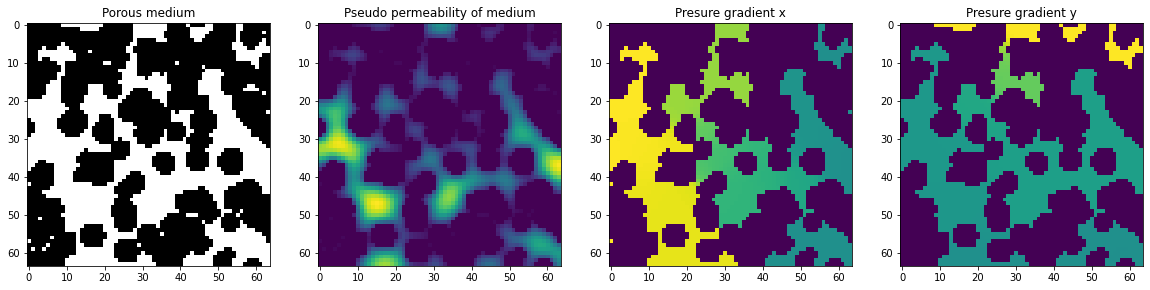

In [7]:
def gen_image_and_data(width = 64, height = 64, num_circles = 150, mean_circle_radius = 3, std_circle_radius = 0.5, show = False):
    i = generate_image_normal(width, height, num_circles, mean_circle_radius, std_circle_radius)
    
    j = calculate_poisson(i)
    
    pressures = calculate_pressures(i,j)
    
    # Simply rotate 90 degrees to determine the gradient in y direction
    pressures90 = calculate_pressures(np.rot90(i), np.rot90(j))
    
    if show:
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,6))
        ax1.imshow(i, cmap='gray')
        ax1.set_title('Porous medium')
        p = ax2.imshow(j)
        ax2.set_title('Pseudo permeability of medium')
        ax3.imshow(pressures)
        ax3.set_title("Presure gradient x")
        ax4.imshow(np.rot90(pressures90, -1))
        ax4.set_title("Presure gradient y")
        
    replacement_k_x = calculate_replacement_k(j, pressures)
    replacement_k_y = calculate_replacement_k(np.rot90(j), pressures90)
    if show:
        print("Replacement permeability x: {:.8f}, y: {:.8f}".format(replacement_k_x, replacement_k_y))
    return i, j, pressures, replacement_k_x, replacement_k_y

start = time.perf_counter()
i, j, pressure, replacement_k_x, replacement_k_y = gen_image_and_data(show = True)
end = time.perf_counter()
print("Data generation took: {:.2f}s".format(end-start))

Porosity: 0.485
Replacement permeability x: 0.10118572, y: 0.14701504
Data generation took: 0.07s


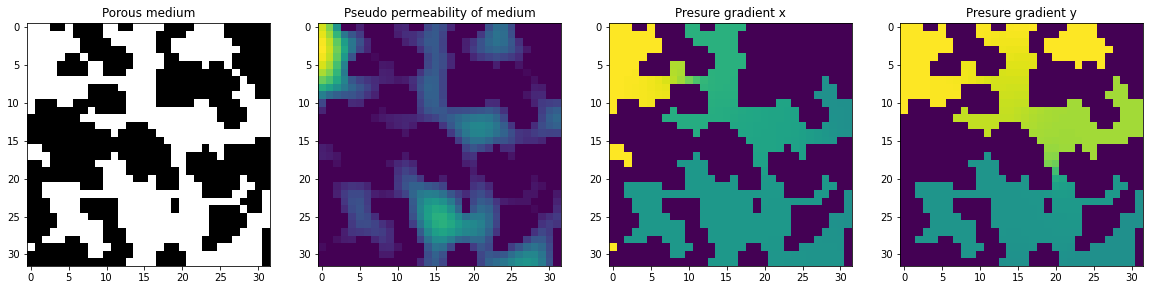

In [8]:
def gen_image_and_data_with_porosity(width = 64, height = 64, porosity = 0.5, mean_circle_radius = 5, std_circle_radius = 0.5, show = False):
    i = generate_image_with_porosity(width, height, porosity, mean_circle_radius, std_circle_radius)
    
    print("Porosity: {:.3f}".format(calculate_porosity(i)))
    
    j = calculate_poisson(i)
    
    pressures = calculate_pressures(i,j)
    
    # Simply rotate 90 degrees to determine the gradient in y direction
    pressures90 = calculate_pressures(np.rot90(i), np.rot90(j))
    
    if show:
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,6))
        ax1.imshow(i, cmap='gray')
        ax1.set_title('Porous medium')
        p = ax2.imshow(j)
        ax2.set_title('Pseudo permeability of medium')
        ax3.imshow(pressures)
        ax3.set_title("Presure gradient x")
        ax4.imshow(np.rot90(pressures90, -1))
        ax4.set_title("Presure gradient y")
        
    replacement_k_x = calculate_replacement_k(j, pressures)
    replacement_k_y = calculate_replacement_k(np.rot90(j), pressures90)
    if show:
        print("Replacement permeability x: {:.8f}, y: {:.8f}".format(replacement_k_x, replacement_k_y))
    return i, j, pressures, replacement_k_x, replacement_k_y

start = time.perf_counter()
i, j, pressure, replacement_k_x, replacement_k_y = gen_image_and_data_with_porosity(width = 32, height = 32, mean_circle_radius = 2,  show = True)
end = time.perf_counter()
print("Data generation took: {:.2f}s".format(end-start))

Replacement permeability x: 0.80213466, y: 0.63864189
Datpoint generation took: 0.15s


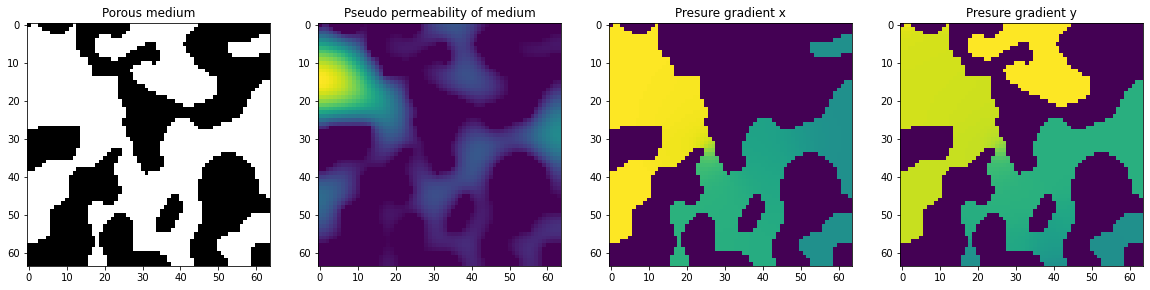

In [9]:
def gen_image_and_data_gaussian(width = 64, height = 64, sigma = 1.75, fraction = 0.3, show = False):
    i = generate_image_gaussian(width, height, sigma, fraction, True)
    
    j = calculate_poisson(i)
    
    pressures = calculate_pressures(i,j)
    
    pressures90 = calculate_pressures(np.rot90(i), np.rot90(j))
    
    if show:
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,6))
        ax1.imshow(i, cmap='gray')
        ax1.set_title('Porous medium')
        p = ax2.imshow(j)
        ax2.set_title('Pseudo permeability of medium')
        ax3.imshow(pressures)
        ax3.set_title("Presure gradient x")
        ax4.imshow(np.rot90(pressures90, -1))
        ax4.set_title("Presure gradient y")
        
    replacement_k_x = calculate_replacement_k(j, pressures)
    replacement_k_y = calculate_replacement_k(np.rot90(j), pressures90)

    if show:
        print("Replacement permeability x: {:.8f}, y: {:.8f}".format(replacement_k_x, replacement_k_y))
    return i, j, pressures, replacement_k_x, replacement_k_y

    
start = time.perf_counter()
i, j, pressure, replacement_k_x, replacement_k_y = gen_image_and_data_gaussian(sigma=3, show = True)
end = time.perf_counter()
print("Datpoint generation took: {:.2f}s".format(end-start))

Flux from pressure gradient: 85.00000000
Flux from analytical calc  : 80.12820513
84.99999999999042
81.38020833333333


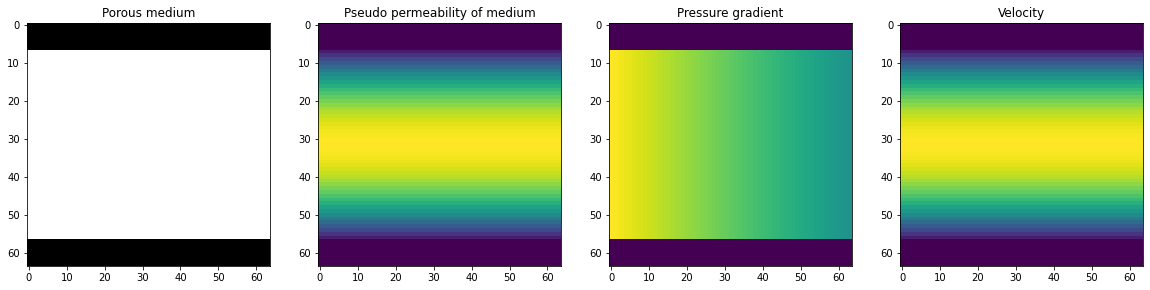

In [78]:
# Flow channel test
# Todo: verify results
def gen_image_and_data_channel(show = False):
    # Create poiseuille flow channel
    h = 50
    start = int((64-h)/2)

    i = np.zeros((64,64))
    i[start:start+h, :] = 1
    j = calculate_poisson(i)
    
    pressures = calculate_pressures(i, j)
    
    pressures90 = calculate_pressures(np.rot90(i), np.rot90(j))
    
    # Assuming fully developed flow
    velocities = -numpy.diff(pressures, prepend=P_left)*j
    
    # Using navier stokes:
    deltaP = (P_right-P_left)/(i.shape[0]+1)
    
    if show:
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,6))
        ax1.imshow(i, cmap='gray')
        ax1.set_title('Porous medium')
        p = ax2.imshow(j)
        ax2.set_title('Pseudo permeability of medium')
        ax3.imshow(pressures)
        ax3.set_title('Pressure gradient')
        ax4.imshow(velocities)
        ax4.set_title('Velocity')
    
    currents = calculate_currents(j, pressures)
    print("Flux from pressure gradient: {:.8f}".format(np.sum(currents)))
    flux = -deltaP*h**3/12
    print("Flux from analytical calc  : {:.8f}".format(flux))
    
    replacement_k_x = calculate_replacement_k(j, pressures)
    replacement_k_y = calculate_replacement_k(np.rot90(j), pressures90)
    
    print(replacement_k_x/2)
    print(h**3/12/(i.shape[1])/2)
    
    return i, j, pressures
i,j, pressures = gen_image_and_data_channel(True)

In [24]:
def save_dataset(images, permeabilities, porosities, filepath):
    np.savez(filepath, images=images, permeabilities=permeabilities, porosities=porosities)

In [25]:
def generate_datapoints_normal(width = 64, height = 64, n = 1000):
    images = []
    permeabilities = []
    porosities = []
    for i in range(n):
        num_circles = np.random.randint(30, 60)
        im, jm, pressure, replacement_k_x, replacement_k_y = gen_image_and_data(width, height, num_circles, 5, 0.5, False)
        images.append(im)
        permeabilities.append((replacement_k_x+replacement_k_y) / 2)
        porosities.append(calculate_porosity(im))
    return np.array(images), np.array(permeabilities), np.array(porosities)

images, permeabilities, porosities = generate_datapoints_normal(n=10000)
save_dataset(images, permeabilities, porosities, "datasets/regular_data_1.npz")

In [360]:
def generate_datapoints_gaussian(width = 64, height = 64, n = 1000):
    images = []
    permeabilities = []
    for i in range(n):
        sigma = np.random.random()*2+1.5
        cutoff = np.random.random()*0.4+0.3
        im, jm, pressure, replacement_k_x, replacement_k_y = gen_image_and_data_gaussian(width, height, sigma, cutoff, False)
        images.append(im)
        permeabilities.append((replacement_k_x+replacement_k_y) / 2)
    return np.array(images), np.array(permeabilities)

images, perms = generate_datapoints_gaussian(n=1000)